In [1]:
import numpy as np
from scipy.stats import norm
np.random.seed(84)

#from pyDOE import lhs

In [2]:
parameter_names = ['beta_W', 'beta_HP', 'D_H', 'D_P', 'Kf_fast', 'Kf_slow', 'Sumax_W', 'Sumax_HP']

typical_range = {
    'beta_W': {'min': 0.15, 'max': 0.3},
    'beta_HP': {'min': 0.15, 'max': 1},
    'D_H': {'min': 0.15, 'max': 0.3},
    'D_P': {'min': 0.15, 'max': 0.5},
    'Kf_fast': {'min': 0.04, 'max': 0.06},
    'Kf_slow': {'min': 0.005, 'max': 0.01},
    'Sumax_W': {'min': 70, 'max': 150},
    'Sumax_HP': {'min': 100, 'max': 350},
}

# Parameter range constraints
# Gharari et al. (2014) = basic range
# Gao et al. (2014) = very large range
# Euser et al. (2015) = most realisitc range
full_range = {
    'beta_W': {'min': 0, 'max': 5},
    'beta_HP': {'min': 0, 'max': 5},
    'D_H': {'min': 0, 'max': 0.6},
    'D_P': {'min': 0, 'max': 1},
    'Kf_fast': {'min': 0.01, 'max': 0.08},
    'Kf_slow': {'min': 0.0008, 'max': 0.01},
    'Sumax_W': {'min': 5, 'max': 250},
    'Sumax_HP': {'min': 5, 'max': 500},
}

# Two-stage sampling:LHS for Independent + Stratified Sampling for Dependent Parameters

In [3]:
import numpy as np
import pyDOE3

def custom_lhs_sample(range_min, range_max, num_samples, decimals=3):
    """Generates LHS samples for a single parameter."""
    lhs_samples = pyDOE3.lhs(n=1, samples=num_samples, criterion='maximin')
    scaled_samples = lhs_samples.flatten() * (range_max - range_min) + range_min
    rounded_samples = np.round(scaled_samples, decimals=decimals)
    return rounded_samples

def stratified_sampling_for_dependent_param(base_values, multiplier, param_min, param_max, num_strata, decimals):
    """Performs stratified sampling for a dependent parameter based on base parameter values."""
    sampled_values = []
    for base_value in base_values:
        lower_bound = max(base_value, param_min)
        upper_bound = min(base_value * multiplier, param_max)
        strata_bounds = np.linspace(lower_bound, upper_bound, num_strata + 1)
        strata_samples = [np.random.uniform(strata_bounds[i], strata_bounds[i+1]) for i in range(num_strata)]
        sampled_values.append(np.random.choice(strata_samples))
    return np.round(sampled_values, decimals)

def generate_custom_samples(param_ranges, num_samples, decimals=3):
    """Generates samples considering direct relationships between parameters."""
    independent_params = ['beta_W', 'D_H', 'Kf_fast', 'Kf_slow', 'Sumax_W']
    samples = {param: custom_lhs_sample(param_ranges[param]['min'], param_ranges[param]['max'], num_samples, decimals)
               for param in independent_params}
    
    # Adjusted dependent parameter sampling using stratified sampling
    num_strata = 10  # Define the number of strata for stratified sampling
    samples['beta_W'] = samples['beta_W'].round(2)
    samples['D_H'] = samples['D_H'].round(2)
    samples['Kf_fast'] = samples['Kf_fast'].round(3)
    samples['Kf_slow'] = samples['Kf_slow'].round(3)
    samples['Sumax_W'] = samples['Sumax_W'].round(0)

    
    samples['beta_HP'] = stratified_sampling_for_dependent_param(samples['beta_W'], 1.1, param_ranges['beta_HP']['min'], param_ranges['beta_HP']['max'], num_strata, 2)
    samples['D_P'] = stratified_sampling_for_dependent_param(samples['D_H'], 1.5, param_ranges['D_P']['min'], param_ranges['D_P']['max'], num_strata, 2)
    samples['Sumax_HP'] = stratified_sampling_for_dependent_param(samples['Sumax_W'], 2, param_ranges['Sumax_HP']['min'], param_ranges['Sumax_HP']['max'], num_strata, 0)  # Rounding to integer if needed

    ordered_samples = [{param: samples[param][i] for param in param_ranges} for i in range(num_samples)]
    return ordered_samples

In [4]:
# Sample size
n_full = 100
n_typical = 100

# Generate custom samples
full_custom_samples = generate_custom_samples(full_range, n_full)
typical_custom_samples = generate_custom_samples(typical_range, n_typical)

combined_samples = full_custom_samples + typical_custom_samples

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_parameter_distributions(samples, parameter_names):
    """
    Plots the distribution of each parameter using histograms.

    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to plot.
    """
    num_params = len(parameter_names)
    fig, axes = plt.subplots(num_params, 1, figsize=(10, 5 * num_params))
    
    if num_params == 1:
        axes = [axes]  # Make it iterable
    
    for ax, param in zip(axes, parameter_names):
        param_values = [sample[param] for sample in samples]
        ax.hist(param_values, bins=20, alpha=0.5, color='blue', density=True) #density = True?
        ax.set_title(f'Distribution of {param}')
        ax.set_xlabel(param)
        ax.set_ylabel('Density')

    plt.tight_layout()
    plt.show()

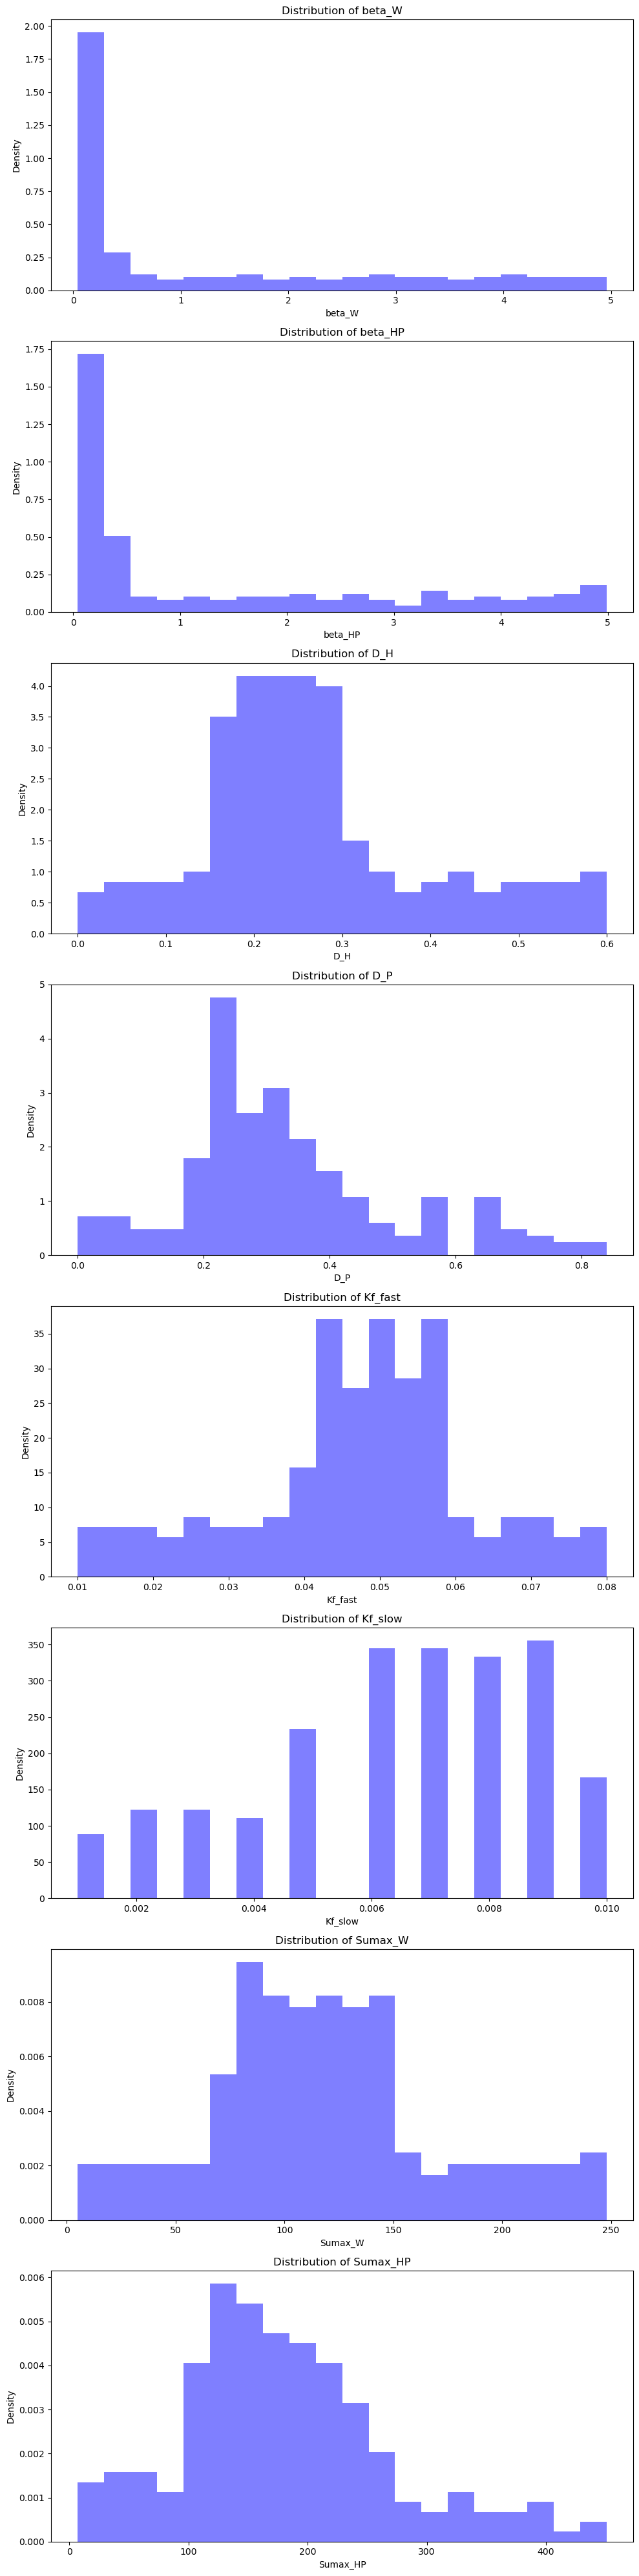

In [6]:
plot_parameter_distributions(combined_samples, parameter_names)

In [7]:
def calculate_coefficient_of_variation(samples, parameter_names):
    """
    Calculates and prints the Coefficient of Variation (CV) for each parameter.
    
    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to calculate CV for.
    """
    for param in parameter_names:
        param_values = np.array([sample[param] for sample in samples])
        mean = np.mean(param_values)
        std_dev = np.std(param_values)
        cv = std_dev / mean if mean else 0  # Avoid division by zero
        print(f'Coefficient of Variation for {param}: {cv:.3f}')

In [8]:
calculate_coefficient_of_variation(full_custom_samples, parameter_names)
#calculate_coefficient_of_variation(typical_custom_samples, parameter_names)

Coefficient of Variation for beta_W: 0.576
Coefficient of Variation for beta_HP: 0.571
Coefficient of Variation for D_H: 0.577
Coefficient of Variation for D_P: 0.589
Coefficient of Variation for Kf_fast: 0.449
Coefficient of Variation for Kf_slow: 0.501
Coefficient of Variation for Sumax_W: 0.555
Coefficient of Variation for Sumax_HP: 0.613


# Run below only when you want to save the final outputs

In [10]:
import os
import pandas as pd

#os.chdir('/mnt/c/Workspace/Ch3/wflow_models/')
os.chdir('/mnt/d/wflow_models/')

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(combined_samples)

#print(df)
# Save the DataFrame to a CSV file
df.to_csv('combined_samples.csv', index=False)

# OLD

In [ ]:
import numpy as np

def sample_parameters(defaults, range_constraints):
    params = {}
    for param, stats in defaults.items():
        mean, std = stats['mean'], stats['std']
        min_val, max_val = range_constraints[param]['min'], range_constraints[param]['max']
        
        # Sample within the specified range
        while True:
            sample = np.random.normal(mean, std)
            if min_val <= sample <= max_val:
                params[param] = sample
                break
    
    # Ensure relationships between parameters
    # This may need several iterations for all conditions to be satisfied
    satisfied = False
    while not satisfied:
        if params['beta_W'] > params['beta_HP']:
            params['beta_W'], params['beta_HP'] = np.random.normal(defaults['beta_W']['mean'], defaults['beta_W']['std']), np.random.normal(defaults['beta_HP']['mean'], defaults['beta_HP']['std'])
        
        if params['D_H'] >= params['D_P']:
            params['D_H'], params['D_P'] = np.random.normal(defaults['D_H']['mean'], defaults['D_H']['std']), np.random.normal(defaults['D_P']['mean'], defaults['D_P']['std'])
        
        if params['Kf_fast'] >= params['Kf_slow']:
            params['Kf_fast'], params['Kf_slow'] = np.random.normal(defaults['Kf_fast']['mean'], defaults['Kf_fast']['std']), np.random.normal(defaults['Kf_slow']['mean'], defaults['Kf_slow']['std'])
        
        if params['Sumax_W'] > params['Sumax_HP']:
            params['Sumax_W'], params['Sumax_HP'] = np.random.normal(defaults['Sumax_W']['mean'], defaults['Sumax_W']['std']), np.random.normal(defaults['Sumax_HP']['mean'], defaults['Sumax_HP']['std'])
        
        # Check if all relationships are satisfied
        satisfied = (params['beta_W'] <= params['beta_HP'] and
                     params['D_H'] < params['D_P'] and
                     params['Kf_fast'] < params['Kf_slow'] and
                     params['Sumax_W'] <= params['Sumax_HP'])
    
    return params

# Example usage
defaults = {
    'beta_W': {'mean': 0.27, 'std': 0.135},
    'beta_HP': {'mean': 0.27, 'std': 0.135},
    'D_H': {'mean': 0.24, 'std': 0.12},
    'D_P': {'mean': 0.24, 'std': 0.12},
    'Kf_fast': {'mean': 0.04, 'std': 0.02},
    'Kf_slow': {'mean': 0.005, 'std': 0.0025},
    'Sumax_W': {'mean': 100, 'std': 50},
    'Sumax_HP': {'mean': 250, 'std': 125}
}

range_constraints = {
    'beta_W': {'min': 0, 'max': 5},
    'beta_HP': {'min': 0, 'max': 5},
    'D_H': {'min': 0, 'max': 1},
    'D_P': {'min': 0, 'max': 1},
    'Kf_fast': {'min': 0.01, 'max': 0.08},
    'Kf_slow': {'min': 0.0008, 'max': 0.01},
    'Sumax_W': {'min': 5, 'max': 250},
    'Sumax_HP': {'min': 5, 'max': 500},
}

sample


2336410


/tmp/ipykernel_15557/1625775067.py:25: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
/tmp/ipykernel_15557/1625775067.py:26: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)


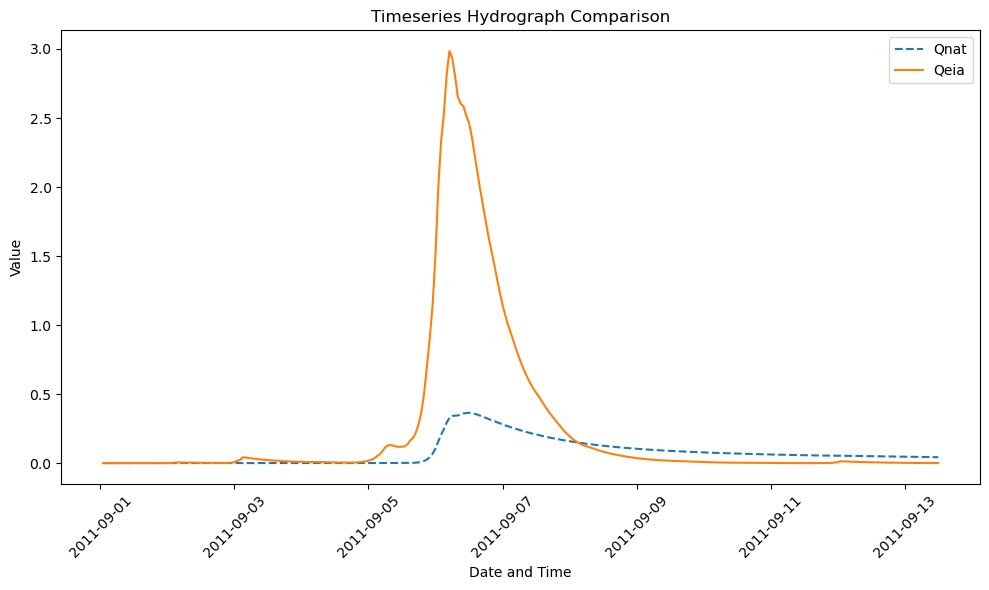

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime


runId = "output/test_dt_Simp2"

outlet = str(int(wsName.split("_")[-1]))
print(outlet)

output_directory = str("../wflow_models/" +wsName + "/" + runId)

# Create a time series index
date_range = pd.date_range(start=datetimestart, periods=lastTimeStep + 1, freq=f'{timestepsecs}s')
date_range = date_range[:-1]

# Paths to the CSV files
#path0 = str(output_directory + '/Prec.csv')
path1 = str(output_directory + '/Qt.csv')
path2 = str(output_directory + '/Qeia.csv')



# Read the last column from both CSV files
df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)
#df3 = pd.read_csv(path3, usecols=['1401'], squeeze=True)
#df4 = pd.read_csv(path4, usecols=['1401'], squeeze=True)
#df5 = pd.read_csv(path5, usecols=['1401'], squeeze=True)
#df6 = pd.read_csv(path6, usecols=['1401'], squeeze=True)


# Assign the date_range as the index directly
df1.index = date_range
df2.index = date_range
#df3.index = date_range
#df4.index = date_range
#df5.index = date_range
#df6.index = date_range


# Ensure the lengths match, trimming if necessary (optional, remove if not needed)
df1 = df1.iloc[:len(date_range)]
df2 = df2.iloc[:len(date_range)]
#df3 = df3.iloc[:len(date_range)]
#df4 = df4.iloc[:len(date_range)]
#df5 = df5.iloc[:len(date_range)]
#df6 = df6.iloc[:len(date_range)]




# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df1.index, df1, label='Qnat', linestyle='--')
plt.plot(df2.index, df2, label='Qeia')
#plt.plot(df3.index, df3, label='BetaKf0Lumped', linestyle='--')
#plt.plot(df4.index, df4, label='Realistic', linestyle='--')
#plt.plot(df5.index, df5, label='None', linestyle='-.')
#plt.plot(df6.index, df6, label='BetaKf0Distributed', linestyle='-.')
plt.title('Timeseries Hydrograph Comparison')
plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm
from pyDOE import lhs

# Define the number of samples
num_samples = 1000

# LHS sampling from a uniform distribution [0, 1) for each parameter (4 parameters in total)
uniform_samples = lhs(4, samples=num_samples)

# Default values and standard deviations for Gaussian transformation
defaults = {
    'beta': {'mean': 2.55, 'std': 1.275},  # Adjust mean and std according to your needs
    'D': {'mean': 0.5, 'std': 0.25},
    'Kf': {'mean': 0.0204, 'std': 0.01},
    'Sumax': {'mean': 350, 'std': 125},
}

# Parameter constraints (example values, adjust as needed)
constraints = {
    'beta_a': {'min': 0.1, 'max': 5},
    'D_b': {'min': 0, 'max': 1},
    'Kf_c': {'min': 0.0008, 'max': 0.04},
    'Sumax_d': {'min': 100, 'max': 600},
}

# Transform uniform LHS samples to Gaussian based on default values
gaussian_samples = np.zeros(uniform_samples.shape)
for i, (key, value) in enumerate(defaults.items()):
    gaussian_samples[:, i] = norm.ppf(uniform_samples[:, i], loc=value['mean'], scale=value['std'])

# Apply constraints (simple example, more complex logic might be required for your specific model)
# Ensure samples are within defined ranges
for i, (key, constraint) in enumerate(constraints.items()):
    gaussian_samples[:, i] = np.clip(gaussian_samples[:, i], constraint['min'], constraint['max'])

# For correlated parameters, like beta, enforce a = d < b = c through sorting or other logic
# This step is highly specific to your model's constraints and might need customization

# Example: Sorting the 'beta' and 'D' samples to enforce a simple constraint
# This is a placeholder step; replace with your specific constraints logic
gaussian_samples[:, [0, 1]] = np.sort(gaussian_samples[:, [0, 1]], axis=1)

# Output
print("Sample of transformed and constrained Gaussian LHS samples for each parameter:")
for i, param in enumerate(defaults.keys()):
    print(f"{param}: {gaussian_samples[:5, i]}")
